# KNN algorithm with own implementation
This notebook presents a complete implementation of KNN algorithm for any numerical data.

Own implementation means that there are no ready-to-use algorithms library used (like sci-kit). 
Only fundamental libraries of universal usage have been used (pandas, numpy, matplotlib).

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Overview
KNN (K-nearest-neighbors) is one of the most fundamental and simple classification method. Although it can be used also for regression, it's much more known as a classification algorithm and the present project focuses on classification.

It's a type of a **supervised** method, so it requires a data set with labels (data points must be assigned to groups). The method doesn't result with a model - the algorithm must be repeated every time we want to assign a new data point to one of existing groups.

## Steps
1. Calculate the distances $d$ between a given point $X=(x_1, x_2, ..., x_n)$ and all other $j$ points $C_1, C_2, ..., C_j$ in $n$ dimensional space, using chosen metric (Euclidian, Mahalandobis or Manhattan).
    For example the distance with Euclidian metric for point $C_i$ will be calculated:
    $$d(X, C_i)=\sqrt{(x_1-c_{i1})^2+(x_2-c_{i2})^2+...+(x_n-c_{in})^2}$$
2. Create a distance ranking ascending, placing the smallest distances at the beginning. 
3. Take top $k$ points, where $k$ should - but not must - be an odd number ($k$ is an arbitrary parameter defining how many points will decide about the assignment; if it's even, ties are possible).
4. Take the most common label $l_m$ within top $k$ points. 

Result: **Point $X$ belongs to $l_m$ group.**

## Implementation
Create a function to calculate a **distance between two given points**.

Assumptions:
* Points have only numerical values.
* Points have the same number of dimensions $n$.

In [129]:
def calc_dist(p1:list, p2:list) -> np.float64:
    """Calculate Euclidian distance between two points."""
    if len(p1) != len(p2):
        return ValueError("Can't calculate distance between points with different number of dimensions.")
    
    dist = 0
    for i, j in zip(p1, p2):
        dist += (i-j)**2
        
    return np.sqrt(dist)

# todo: maybe some asserts?
calc_dist([3,1], [2,2])

1.4142135623730951

Using the function defined above calculate **distances between a given point and each labeled data point**.

Assumptions:
* The point must be in a type of list or array with length of $n$.
* The data set must be in a form of pandas DataFrame* with $n+1$ column, where last column contains labels.
* Each row of the DataFrame represent a point, because each column represent a dimension.

*DataFrame format is very widely used and most labeled data is stored quite so.

In [131]:
def calc_all_dists(point:list, df:pd.DataFrame) -> pd.DataFrame:
    """Calculates distances between given point and all points in DataFrame."""
    if len(point) != len(df.columns)-1:
        return ValueError("Can't calculate distance between points with different number of dimensions.")
    
    # making a copy of existing DataFrame, so it's not changed
    df_dists = df.copy()
    # create a new column for distances
    df_dists['dist_from_p'] = 0
    
    for i, row in df_dists.iterrows():
        # iterating over DF, but without 'labels' and 'dist_from_p' columns
        nextpoint = [unit for unit in row[:-2]]
        # calculate a distance for each row (each point)
        dist = calc_dist(nextpoint, point)
        # input calculated value into DF
        df_dists.loc[i, 'dist_from_p'] = dist
    
    # return values sorted ascendingly by distances
    return df_dists.sort_values(by='dist_from_p')

Choose top $k$ points as winners. 

In [133]:
def choose_winner(df:pd.DataFrame, k:int, labels_col:str):
    winners = df.iloc[:k]
    labels = list(winners[labels_col])
    return max(set(labels), key = labels.count)

Define last function to **wrap it all up**:

In [134]:
def knn(df:pd.DataFrame, k:int, point:list, labels_col='labels'):
    distances = calc_all_dists(point, df)
    return choose_winner(distances, k, labels_col)

Since `choose_winner` function ends the algorithm, let's test the implemented code on sample data.

## Test the implementation
The test will be conducted on two data samples: 2-dimensional and 3-dimensional. In both cases we will test $k=5$.

Data samples:
* DataFrame of 2 and 3 vectors.
* A vector contains $n$ values.
* Values are randomly selected from overlapping intervals.

In [135]:
import random

n=20
# seed for same random results
random.seed(30)

# x,y,z: coordinates for test data
def generate_randoms(n, threshold):
    return [random.randint(0, n*2) for i in range(n)] \
        + [random.randint(threshold, threshold+n*2) for i in range(n)] \
        + [random.randint(threshold*2, threshold*2+n*2) for i in range(n)]

x = generate_randoms(n, 30)
y = generate_randoms(n, 30)
z = generate_randoms(n, 30)

labels = [0]*n + [1]*n + [2]*n

# test data: 2-d + labels
data_2d = pd.DataFrame(data={'x':x, 'y':y, 'labels':labels})

# test data: 3-d + labels
data_3d = pd.DataFrame(data={'x':x, 'y':y, 'z':z, 'labels':labels})

Let's examine generated data by drawing them on the plot.

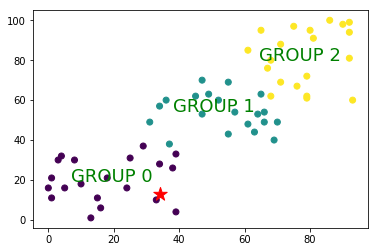

In [155]:
# DRAW 2-D PLOT

def generate_rand_point_2d():
    # single 2-d point
    point_2d_x = random.randint(data_2d.x.min(), data_2d.x.max())
    point_2d_y = random.randint(data_2d.y.min(), data_2d.y.max())

    return [point_2d_x, point_2d_y]

point_2d = generate_rand_point_2d()

def plot_2d(data_2d, point_2d):
    plt.scatter(data_2d.x, data_2d.y, c=data_2d.labels)
    plt.scatter(point_2d[0], point_2d[1], color='r', marker='*', s=200)

    for i in [0,1,2]:
        label_x = (data_2d[data_2d['labels'] == i].x.min() + data_2d[data_2d['labels'] == i].x.max())/2
        label_y = (data_2d[data_2d['labels'] == i].y.min() + data_2d[data_2d['labels'] == i].y.max())/2
        plt.text(label_x, label_y, s="GROUP "+str(i), color='g', fontsize=18, horizontalalignment='center')

    plt.show()
    
plot_2d(data_2d, point_2d)

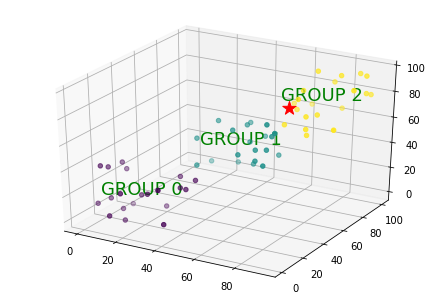

In [156]:
# DRAW 3-D PLOT
from mpl_toolkits.mplot3d import Axes3D

def generate_rand_point_3d():
    point_3d_x = random.randint(data_3d.x.min(), data_3d.x.max())
    point_3d_y = random.randint(data_3d.y.min(), data_3d.y.max())
    point_3d_z = random.randint(data_3d.z.min(), data_3d.z.max())

    return [point_3d_x, point_3d_y, point_3d_z]

point_3d = generate_rand_point_3d()

def plot_3d(data_3d, point_3d):
    fig = plt.figure()
    ax = Axes3D(fig)

    ax.scatter(data_3d.x, data_3d.y, data_3d.z, c=data_3d.labels)
    ax.scatter(point_3d[0], point_3d[1], point_3d[2], c='r', marker='*', s=200)

    # define min and max for each group to show group labels
    for i in [0,1,2]:
        label_x = (data_3d[data_3d['labels'] == i].x.min() + data_3d[data_3d['labels'] == i].x.max())/2
        label_y = (data_3d[data_3d['labels'] == i].y.min() + data_3d[data_3d['labels'] == i].y.max())/2
        label_z = (data_3d[data_3d['labels'] == i].z.min() + data_3d[data_3d['labels'] == i].z.max())/2
        ax.text(label_x, label_y, label_z, s="GROUP "+str(i), color='g', fontsize=18, horizontalalignment='center')

    plt.show()
    
plot_3d(data_3d, point_3d)

Data looks good. Let's try the algorithm!

**2-D test**:

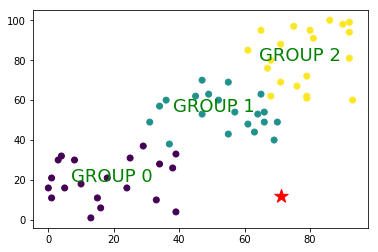

Result for KNN (2-D data, k=5): GROUP 1


In [157]:
test_point_2d = generate_rand_point_2d()
knn_2d_1 = knn(data_2d, k=5, point=test_point_2d)

plot_2d(data_2d, test_point_2d)

print("Result for KNN (2-D data, k=5): GROUP", knn_2d_1)
# feel free to refresh! each time a new random point is generated

**3-D test**:

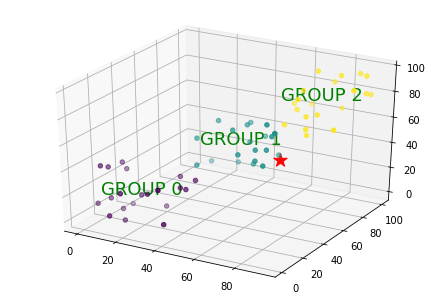

Result for KNN (3-D data, k=5): GROUP 1


In [160]:
test_point_3d = generate_rand_point_3d()
knn_3d_1 = knn(data_3d, k=5, point=test_point_3d)

plot_3d(data_3d, test_point_3d)

print("Result for KNN (3-D data, k=5): GROUP", knn_3d_1)
# feel free to refresh! each time a new random point is generated